In [5]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [13]:
NUM_TRADING_DAYS = 252
NUM_PORTFOLIOS = 10000

stocks = ["AAPL", "WMT", "TSLA", "GE", "AMZN", "DB"]

start_date = "2016-01-01"
end_date = "2021-01-01"

In [7]:
def download_data():
    stock_data = {}

    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    
    return pd.DataFrame(stock_data)

In [8]:
def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [9]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [10]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [12]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

In [19]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker="o")
    plt.grid(True)
    plt.xlabel("Expected Volatility")
    plt.ylabel("Expected Return")
    plt.colorbar(label="Sharpe Ratio")
    plt.show()

In [17]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)

        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))
    
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [21]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return/portfolio_volatility])

In [22]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [23]:
def optimize_portfolio(weights, returns):
    constraints = {"type" : "eq", "fun" : lambda x : np.sum(x) - 1}

    bounds = tuple((0, 1) for _ in range(len(stocks)))

    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method="SLSQP", bounds=bounds, constraints=constraints)

In [24]:
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum["x"].round(3))
    print("Expected return, volatility and Sharpe ratio: ", statistics(optimum["x"].round(3), returns))

In [25]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets/portfolio_vols, marker="o")
    plt.grid(True)
    plt.xlabel("Expected Volatility")
    plt.ylabel("Expected Return")
    plt.colorbar(label="Sharpe Ratio")
    plt.plot(statistics(opt["x"], rets)[1], statistics(opt["x"], rets)[0], "g*", markersize=20)
    plt.show()

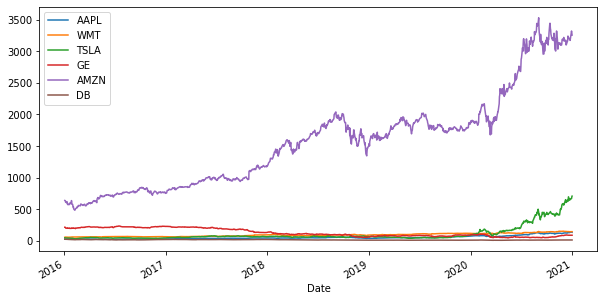

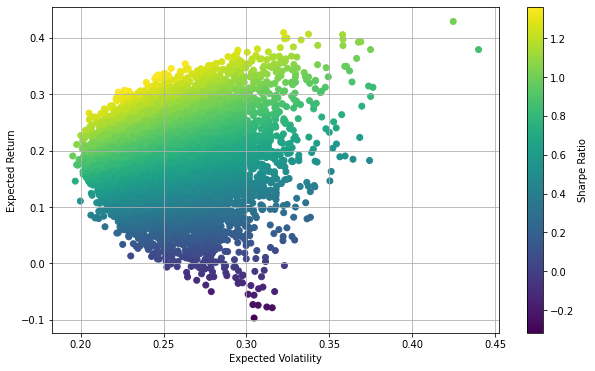

Optimal portfolio:  [0.244 0.362 0.144 0.    0.25  0.   ]
Expected return, volatility and Sharpe ratio:  [0.314189   0.22409528 1.40203307]


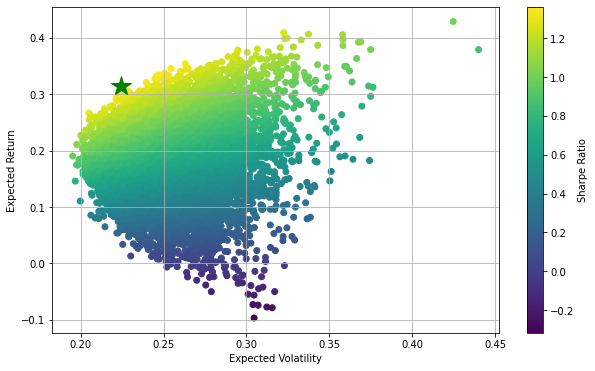

In [27]:
if __name__ == "__main__":
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)

    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)

    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)